In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array

**Read dataset**

In [2]:
filtered_clothing = pd.read_csv('../../filtered_clothing_dataset.csv')

**Split dataset in training and testing set**

In [3]:
eighty_pct = int(0.8*len(filtered_clothing))
  
train_set = filtered_clothing.iloc[:(eighty_pct-1), :] 
test_set = filtered_clothing.iloc[eighty_pct:, :] 
  
train_set.to_csv("train_data.csv", index=False)
test_set.to_csv("test_data.csv", index=False)

**Loading the dataset**

In [4]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [5]:
# image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data['id'] = train_data['id'].astype(str) + '.jpg'
test_data['id'] = test_data['id'].astype(str) + '.jpg'

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='../../filtered_images',
    x_col="id",
    y_col="articleType",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True) 

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='../../filtered_images',
    x_col="id",
    y_col="articleType",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 22344 validated image filenames belonging to 24 classes.
Found 5587 validated image filenames belonging to 24 classes.


**Loading the InceptionResNetV2 pretrained model**

In [6]:
base_model = InceptionResNetV2(
    include_top=False,
    weights='imagenet', 
    input_shape=(img_width, img_height, 3))

base_model.trainable = False

**Adding custom classification head on top of InceptionResNetV2**

In [7]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(24, activation='softmax')  # 24 main article types in the dataset
])

**Compiling the model**

In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ ?                           │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

**Model training**

In [9]:
# number of training and validation steps
train_steps_per_epoch = len(train_data) // batch_size
test_steps_per_epoch = len(test_data) // batch_size

# model training
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_steps_per_epoch)

Epoch 1/10


C:\Users\catal\anaconda3\envs\fashion_product_images_small\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


698/698 ━━━━━━━━━━━━━━━━━━━━ 2950s 4s/step - accuracy: 0.6570 - loss: 1.0287 - val_accuracy: 0.7789 - val_loss: 0.6142
Epoch 2/10
  1/698 ━━━━━━━━━━━━━━━━━━━━ 44:13 4s/step - accuracy: 0.6250 - loss: 0.7124

C:\Users\catal\anaconda3\envs\fashion_product_images_small\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


698/698 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6250 - loss: 0.3567 - val_accuracy: 0.8421 - val_loss: 0.2253
Epoch 3/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 2944s 4s/step - accuracy: 0.7868 - loss: 0.5782 - val_accuracy: 0.7989 - val_loss: 0.5581
Epoch 4/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7188 - loss: 0.3442 - val_accuracy: 0.8421 - val_loss: 0.2551
Epoch 5/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 2967s 4s/step - accuracy: 0.8006 - loss: 0.5258 - val_accuracy: 0.8078 - val_loss: 0.5406
Epoch 6/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9062 - loss: 0.2346 - val_accuracy: 0.7368 - val_loss: 0.2637
Epoch 7/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 3121s 4s/step - accuracy: 0.8174 - loss: 0.4834 - val_accuracy: 0.8145 - val_loss: 0.5310
Epoch 8/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7812 - loss: 0.2021 - val_accuracy: 0.7895 - val_loss: 0.2897
Epoch 9/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 3239s 5s/step - accuracy: 0.8201 - loss: 0.4745 - val_accuracy: 0.813

**Saving the model**

In [10]:
model.save('InceptionResNetV2_model_13052024_10epochs_article_type.keras')
print("Saving the model as InceptionResNetV2_model_13052024_10epochs_article_type.keras")

Saving the model as InceptionResNetV2_model_13052024_10epochs_article_type.keras


**Model evaluation**

In [11]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# predicting the probabilities for the test set
y_pred_proba = model.predict(test_generator)

# converting the probabilities to class predictions
y_pred = np.argmax(y_pred_proba, axis=1)

# getting the true labels
y_true = test_generator.classes

# computing the precision, recall, f1-score, support
print("Classification Report:")
print(classification_report(y_true, y_pred))

# computing the AUC-ROC score with the multi_class='ovr'
auc_roc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
print("AUC-ROC Score (ovr):", auc_roc)

# computing the AUC-ROC score with the multi_class='ovo'
auc_roc_ovo = roc_auc_score(y_true, y_pred_proba, multi_class='ovo')
print("AUC-ROC Score (ovo):", auc_roc_ovo)

174/174 ━━━━━━━━━━━━━━━━━━━━ 617s 4s/step - accuracy: 0.8199 - loss: 0.5447
Test Loss: 0.5308694243431091
Test Accuracy: 0.8178879022598267
175/175 ━━━━━━━━━━━━━━━━━━━━ 597s 3s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       134
           1       0.46      0.72      0.56        40
           2       0.69      0.83      0.75       550
           3       0.87      0.92      0.89        63
           4       0.68      0.68      0.68        79
           5       0.47      0.09      0.15       102
           6       0.77      0.91      0.83       187
           7       0.72      0.94      0.82       134
           8       0.94      0.96      0.95       342
           9       0.68      0.81      0.74       259
          10       0.57      0.50      0.53        50
          11       0.88      0.80      0.84       124
          12       0.67      0.14      0.24        14
          13       0.95      0.61     

**Accuracy per article type**

175/175 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step
Accuracy for article type 'Backpacks': 0.9626865671641791
Accuracy for article type 'Capris': 0.725
Accuracy for article type 'Casual Shoes': 0.8345454545454546
Accuracy for article type 'Clutches': 0.9206349206349206
Accuracy for article type 'Dresses': 0.6835443037974683
Accuracy for article type 'Flats': 0.08823529411764706
Accuracy for article type 'Flip Flops': 0.9090909090909091
Accuracy for article type 'Formal Shoes': 0.9402985074626866
Accuracy for article type 'Handbags': 0.9590643274853801
Accuracy for article type 'Heels': 0.8146718146718147
Accuracy for article type 'Jackets': 0.5
Accuracy for article type 'Jeans': 0.7983870967741935
Accuracy for article type 'Laptop Bag': 0.14285714285714285
Accuracy for article type 'Leggings': 0.6060606060606061
Accuracy for article type 'Sandals': 0.6376811594202898
Accuracy for article type 'Shirts': 0.9727272727272728
Accuracy for article type 'Shorts': 0.8598130841121495
Accuracy for article

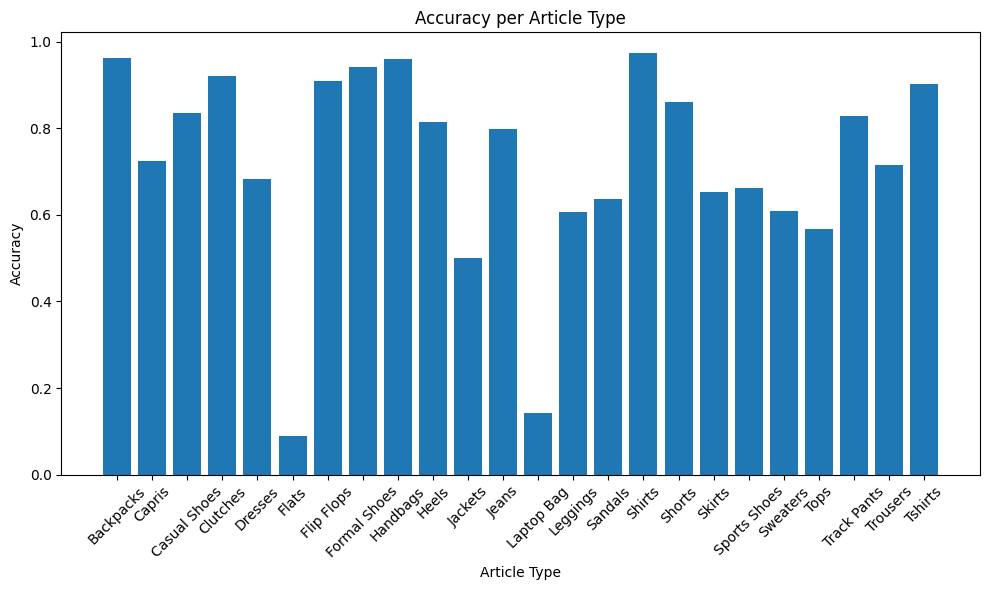

In [12]:
# converting the class_labels to a list
class_labels = list(train_generator.class_indices.keys())

# predicting the probabilities for the test set
predictions = model.predict(test_generator)

# getting the predicted labels for each image
predicted_labels = [class_labels[i] for i in np.argmax(predictions, axis=1)]

# getting the true labels for each image
true_labels = [class_labels[i] for i in test_generator.classes]

# initializing a dictionary to store the counts of the correct predictions and the total counts for each subcategory
subcategory_counts = {class_label: [0, 0] for class_label in class_labels}

# iterating through each prediction and updating the counts
for true_label, predicted_label in zip(true_labels, predicted_labels):
    subcategory_counts[true_label][1] += 1
    if true_label == predicted_label:
        subcategory_counts[true_label][0] += 1

# computing the accuracy for each subcategory
subcategory_accuracies = {class_label: (count[0] / count[1]) if count[1] != 0 else 0 for class_label, count in subcategory_counts.items()}

# displaying the accuracy per subcategory
for class_label, accuracy in subcategory_accuracies.items():
    print(f"Accuracy for article type '{class_label}': {accuracy}")

# plotting the accuracy per subcategory
plt.figure(figsize=(10, 6)) 
plt.bar(subcategory_accuracies.keys(), subcategory_accuracies.values())
plt.xlabel('Article Type')
plt.ylabel('Accuracy')
plt.title('Accuracy per Article Type')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

**Predict the label and accuracy of an external image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


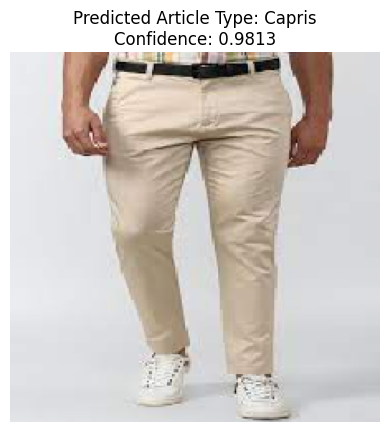

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


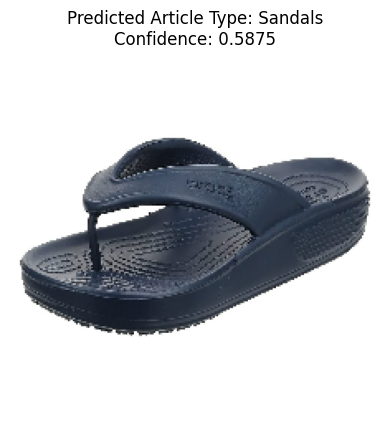

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


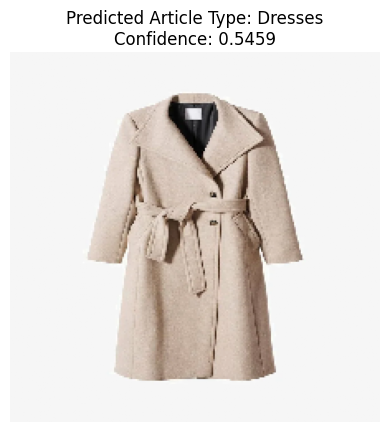

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


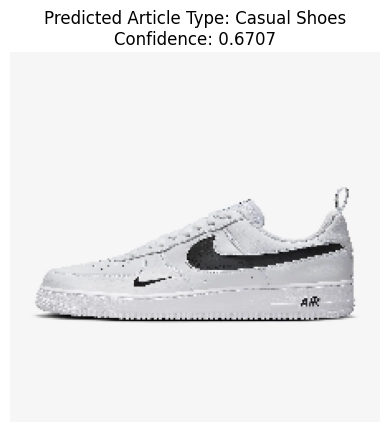

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


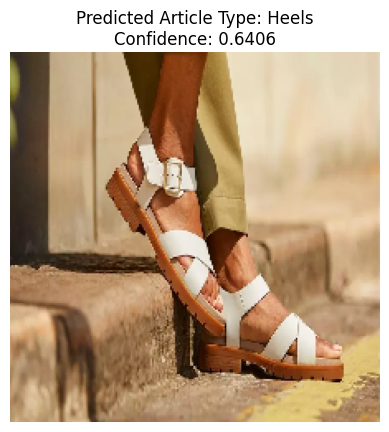

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


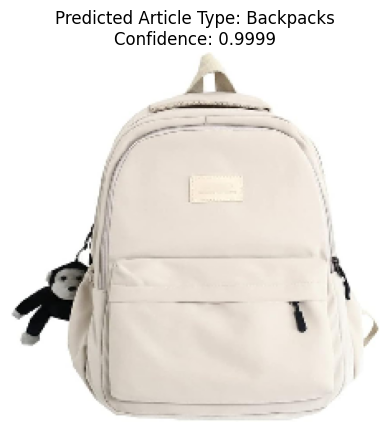

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


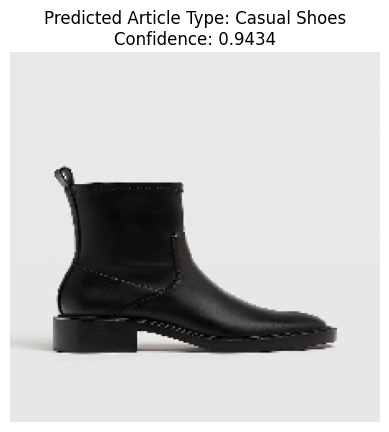

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


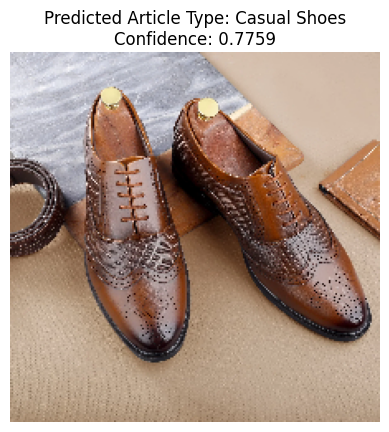

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


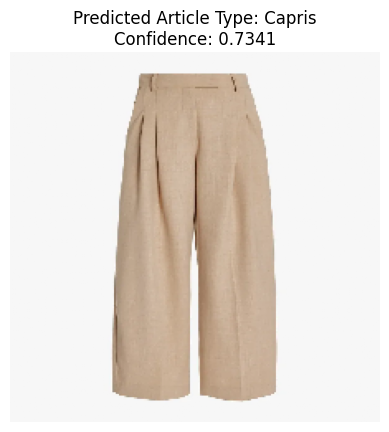

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


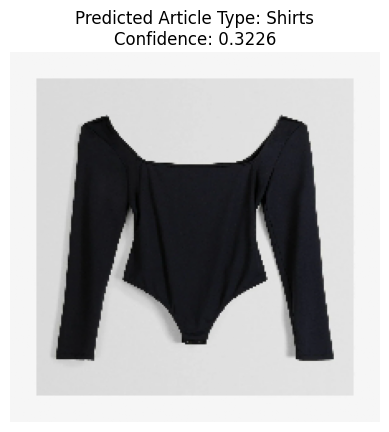

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


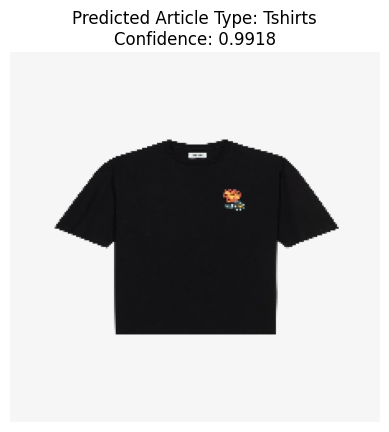

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


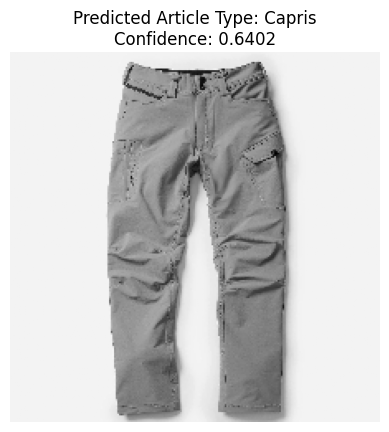

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


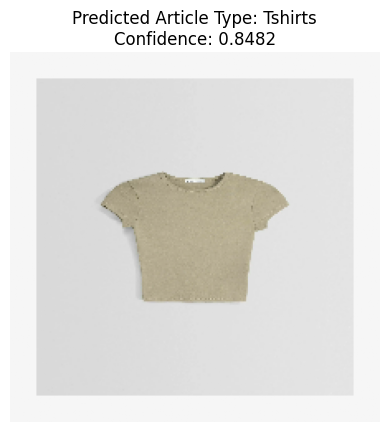

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


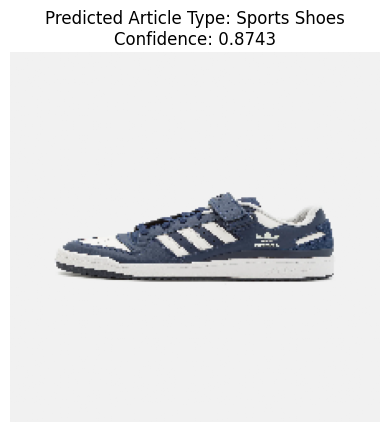

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


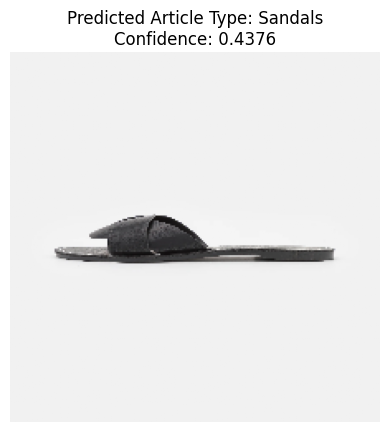

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


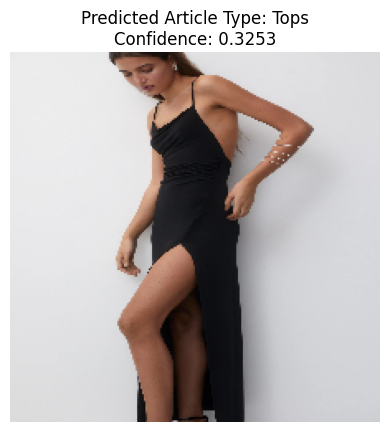

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


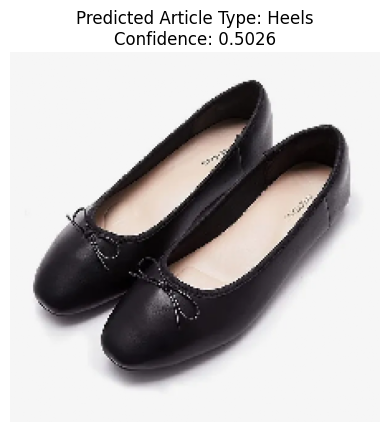

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


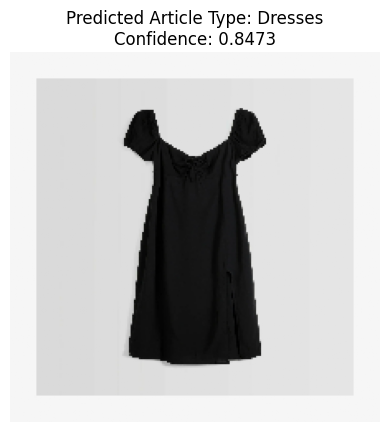

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


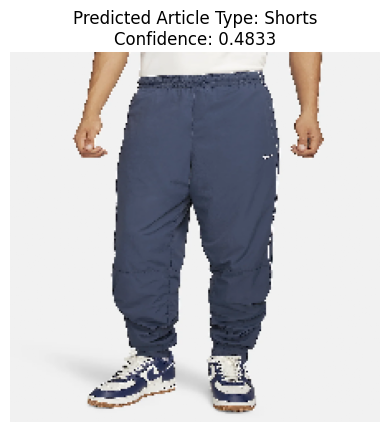

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


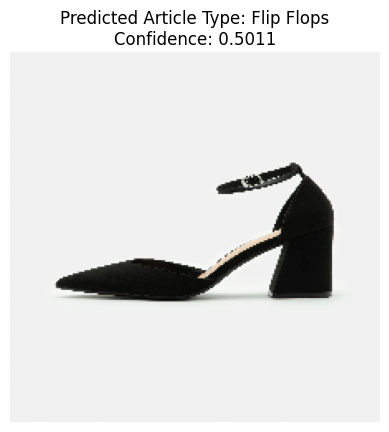

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


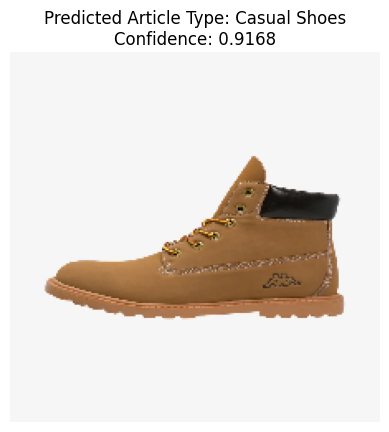

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


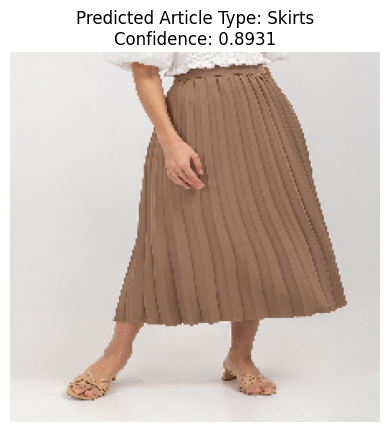

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


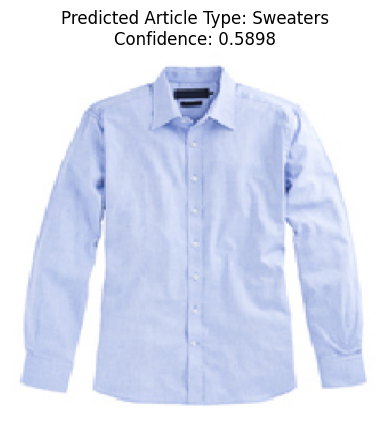

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


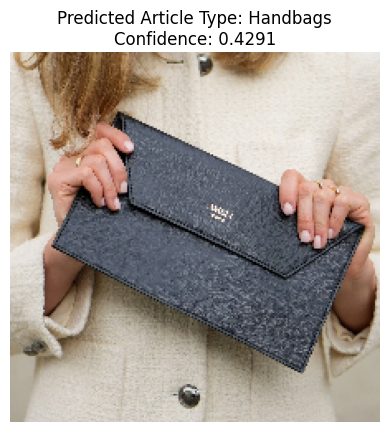

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


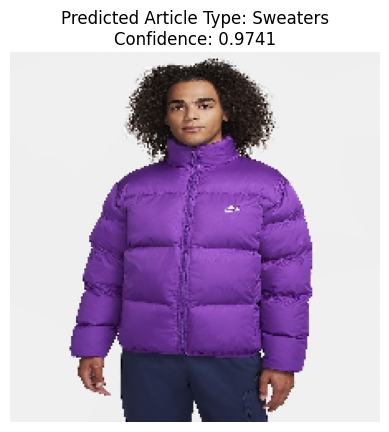

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


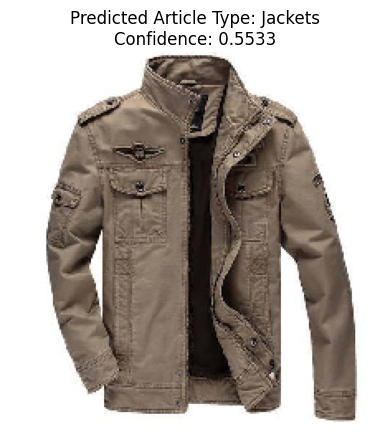

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


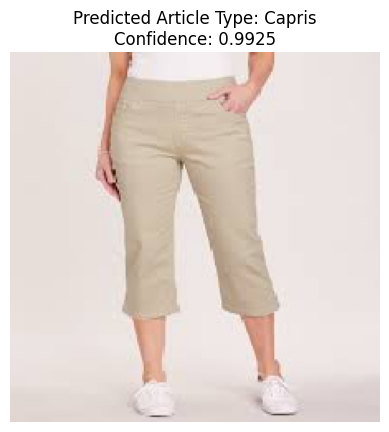

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


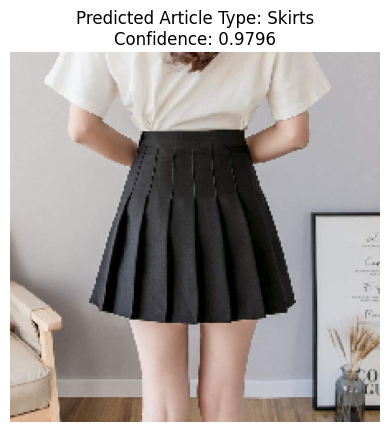

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


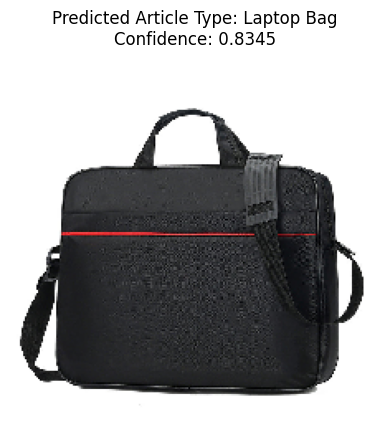

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


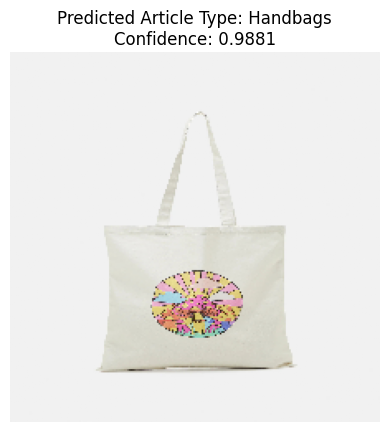

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


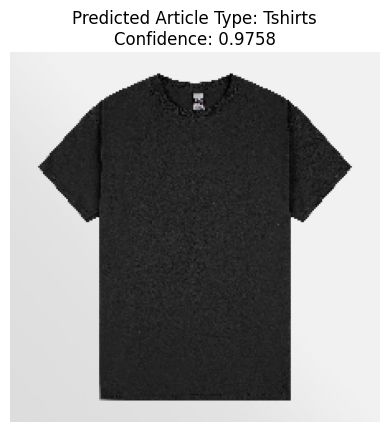

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


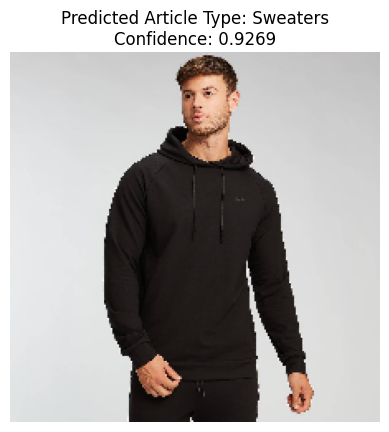

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


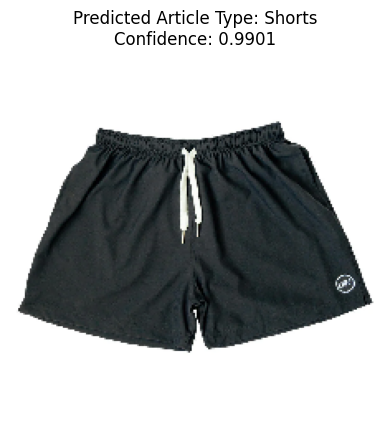

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


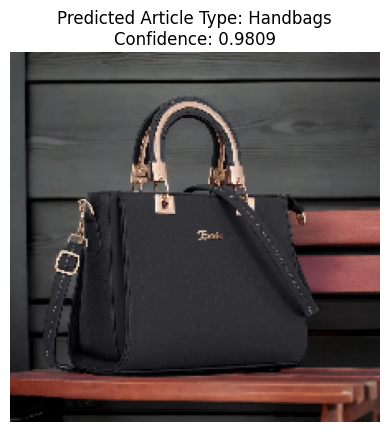

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


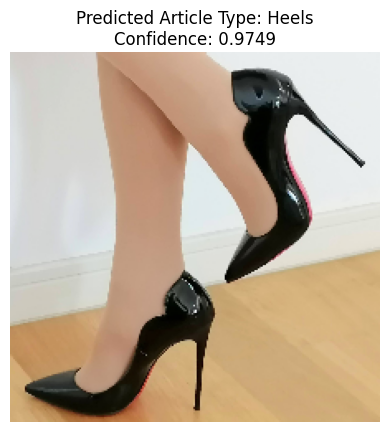

In [13]:
# function to make predictions with dynamically generated category labels
def predict_image_category_with_dynamic_labels(image_path, model, train_generator):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)

    # getting the index of the class with the highest probability
    predicted_class = np.argmax(predictions[0]) 
    
    # generating a mapping of the class indices to category labels
    class_labels = {i: label for i, label in enumerate(train_generator.class_indices.keys())}

    # getting the corresponding label using the class index
    predicted_label = class_labels[predicted_class]  

    # computing the confidence score of the prediction
    confidence = predictions[0][predicted_class] 
    
    return predicted_label, confidence, img_array

def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0 
    return img_array

def parse_images_in_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.webp', '.hpg', '.png'))]
    images_data = []
    for file in image_files:
        image_path = os.path.join(folder_path, file)
        preprocessed_image = preprocess_image(image_path)
        images_data.append((image_path, preprocessed_image))
    return images_data


images_folder_path = '../../clothing_test_dataset/'

images_data = parse_images_in_folder(images_folder_path)

for image_path, preprocessed_image in images_data:
    # predicting the category and the confidence for the image
    predicted_label, confidence, img_array = predict_image_category_with_dynamic_labels(image_path, model, train_generator)
    
    # displaying the image along with predicted category and confidence
    plt.imshow(img_array[0])
    plt.title(f'Predicted Article Type: {predicted_label}\nConfidence: {confidence:.4f}')
    plt.axis('off')
    plt.show()
